# Multicellular Network Growth
***

This notebook shows growth simulations of cell processes in a tissue.

***

First, we import all relevant libraries and the framework itself:

In [1]:
import numpy as np
from time import time as timet
import concurrent.futures
import os
import itertools
import multiprocessing
from pathlib import Path

import tifffile as tif

import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from mpl_toolkits.mplot3d import Axes3D

Now we need to import the main simulation classes as well as some auxiliary modules for configuration and plotting:

In [2]:
# Import the framework's main module
import Initialize_Network_Growing as ing

# This python file loads the parameter setting for the growth simulation
import Start_Conditions.Parameter_Importer as Parameter_Importer

# This python file initializes the starting nodes and growth cones: 
import Start_Conditions.Node_Maker as Node_Maker

# This loads the images containing the structure of teh environment:
import Start_Conditions.StructField_Maker as StructField_Maker

# Growth step functionality
import Math_and_Simulation.Step_Maker as Step_Maker

# Functions for plotting and making movies
import Plots_and_Movies.Plot_Maker as Plot_Maker
import Plots_and_Movies.Movie_Maker as Movie_Maker

# Functions for generating the networkx graph
import Network_Graph_Construction.Network_X as Network_X
import Network_Graph_Construction.Update_Network as Update_Network

***
## 2) Setup the simulation environment

In our scenario, the network forms between three layers of osteocytes, representing a simplified geometry similar to lamellar bone. From each cell, N processes grow out (ref Buenzli).

We start by defining the cell centers in a 3-2-3, 2-3-2, 3-2-3 arrangement inside a 256³ cube:


In [3]:
cells = np.array([[128,64,128],[128,128,128],[128,192,128],
                  [64,96,128], [64,160,128],
                  [192,96,128],[192,160,128],
                  [128,96,96], [128,160,96],
                  [64,64,96],  [64,128,96],  [64,192,96],
                  [192,64,96], [192,128,96], [192,192,96],
                  [128,96,160],[128,160,160],
                  [64,64,160], [64,128,160], [64,192,160],
                  [192,64,160],[192,128,160],[192,192,160]]);



To get a quick 3-cell simulation run, execute this cell instead:

In [4]:
cells = np.array([[128,64,128],[128,128,128],[128,192,128]]);

Define number of cells and cell shape:

In [5]:
N_cells = cells.shape[0]

# offset of cell surface from cell center
w = 7
l = 12
h = 4

Next, we define the outgrowing cell processes at each cell location, pointing outwards and equally distributed in all directions.

After setting the number of outgrowing processes per cell, we first generate the angles (az, pol) of the outgrowing processes for each cell:

In [6]:
# number of outgrowing processes per cell
N = 20

# equally distributed angles
idx = np.arange(0, N, dtype=float) + 0.5;
phi = np.arccos(1 - 2*idx/N);
theta = np.pi * idx * (1 + 5**0.5);

# azimuth and polar angles of initial direction
az = np.mod(np.rad2deg(phi),180);
pol = np.mod(np.rad2deg(theta),360);

Now we also need the starting positions on the surface of each cell, again equally distributed (for details, see other notebook):

In [7]:
# positions on cell surface relative to center
x = w * np.cos(theta) * np.sin(phi);
y = l * np.sin(theta) * np.sin(phi);
z = h * np.cos(phi)

By combining the starting positions and angles relative to the cell center with the positions of all N cell centers, we can now generate the arrays with all positions:

In [8]:
# generate column vectors for positions of all cells
xc = np.squeeze(np.repeat(cells[:,0],N) + np.tile(x,(1,N_cells)));
yc = np.squeeze(np.repeat(cells[:,1],N) + np.tile(y,(1,N_cells)));
zc = np.squeeze(np.repeat(cells[:,2],N) + np.tile(z,(1,N_cells)))

Same for the angles:

In [9]:
azc = np.squeeze(np.tile(az,(1,N_cells)));
polc = np.squeeze(np.tile(pol,(1,N_cells)));

Finally, we need the cell index for the last column:

In [10]:
# index column to identify processes from the same cell
idc = np.repeat(np.arange(1, N_cells+1, dtype=float),N);

We stack the arrays together as columns and write them to the config file:

In [11]:
# save starting positions to text file
np.savetxt('Examples/Osteocytes/starting_positions_ocy.csv',np.column_stack((xc,yc,zc,azc,polc,idc)), fmt='%.2f', delimiter=',', header='Starting Positions\nX,Y,Z,Az,Pol,CN')

***

## 3) Perform simulation

Set the location of the configuration files (.csv text files):

In [12]:
# Path to this notebook
home = os.getcwd() 

# Locations of csv configuration files
path_multilayer = home + '/Parameter_Files/multilayer_dir_parameters.csv'
path_startpar = home + '/Examples/Osteocytes/starting_positions_ocy.csv'
path_growth = home + '/Examples/Osteocytes/growth_parameters.csv'
path_internal = home + '/Examples/Osteocytes/internal_parameters.csv'
path_structured_images = home + '/Examples/Osteocytes/structured_image_dir.csv'

Generate the structured image - an oriented bone matrix with perpendicular lamellae where the cells are:

In [ ]:
# generate and save empty volume 
fe = np.zeros((256,256,256));
tif.imsave(home +'/Examples/Osteocytes/empty.tif',np.float32(fe))

# create 256³ structured image procedurally
f = np.zeros((4,4));

# some collagen fibers
f[0:2,0:2] = 300;

# tile to fill volume
f2 = np.tile(f, [256,64,64]);

# introduce some lamellae with perpendicular fibers
f2[64:256:64,:,::16] = 1;
f2[64:256:64,::16,:] = 1;

# save at the appropriate position
tif.imsave(home +'/Examples/Osteocytes/fiberz.tif',np.float32(f2))

Extract settings and initialize the dictionaries of network objects as well as the computation grid:

In [13]:
# Generate feature maps from image data of growth environment
features = ing.StructField_Maker.structured_field(path_structured_images, home, sigma_divd=2, sigma_divt1=2, sigma_divt2=2)

# Initialise the computation grid
field_ref = ing.StructField_Maker.interpol_external_fields(path_multilayer)

# Initialize the object dictionaries
obj_par_env = ing.init_objects_parameter_enviroment(path_startpar,path_internal,path_growth,path_multilayer)

The number of starting cones is : 60


The growth process is implemented as parallel simulation, therefore the data need to be transferred into shared memory objects, using the [**manager concept**](https://docs.python.org/3/library/multiprocessing.html#managers) from the python [**multiprocessing**](https://docs.python.org/3/library/multiprocessing.html) library:

In [14]:
# Extract individual dictionaries
cod, nod, edd, flavour, ed_names, no_names, co_names, field, steps, instances, dim, radius  = obj_par_env

# Create shared memory proxy objects for all parameter and class objects
mgr, eddp, nodp, flavourp, ed_namesp, \
no_namesp, co_namesp, fieldp, forcep = ing.init_manager_init(edd, nod, flavour,
                                                            ed_names, no_names,
                                                            co_names, field,
                                                            field_ref)

# Transfer proxy objects to the correct namespace (needed when running in notebook)
ing.mgr = mgr
ing.eddp = eddp
ing.nodp = nodp
ing.flavourp = flavourp
ing.ed_namesp = ed_namesp
ing.no_namesp = no_namesp
ing.co_namesp = co_namesp
ing.fieldp = fieldp
ing.forcep = forcep


Finally, set the number of instances (simulation steps) and substeps per instance, and run the parallel simulation: 

Instance number  0  with  5  steps  and  60 cones,  60 edges and  63 nodes.
Instance number  1  with  5  steps  and  75 cones,  84 edges and  87 nodes.
Instance number  2  with  5  steps  and  107 cones,  128 edges and  131 nodes.
Instance number  3  with  5  steps  and  135 cones,  166 edges and  169 nodes.
Instance number  4  with  5  steps  and  150 cones,  188 edges and  191 nodes.
Instance number  5  with  5  steps  and  175 cones,  224 edges and  227 nodes.
Instance number  6  with  5  steps  and  211 cones,  280 edges and  283 nodes.
Instance number  7  with  5  steps  and  240 cones,  324 edges and  327 nodes.
Instance number  8  with  5  steps  and  264 cones,  366 edges and  369 nodes.
Instance number  9  with  5  steps  and  302 cones,  424 edges and  427 nodes.
After updating the merge events there are 545 edges and  513 nodes in the network graph.
Operation for 357 growth cones with 50 growth steps took 1.1714552481969198 min


/home/phk57mf/pythrahyper_net/Plots_and_Movies/Plot_Maker.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


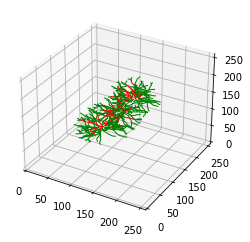

In [15]:
# Starting the growth process simulation

%matplotlib inline

instances = 10
steps = 5

growing_results = ing.init_par_growing(cod, nod, edd, steps,instances, dim, radius,eddp, nodp, flavourp, fieldp, ed_namesp, no_namesp, co_namesp,forcep,
                                  timer = True,
                                  plot = True,
                                  Voronoi = False,
                                  network_x = False)

cod, nod, edd, flavour, ed_names, no_names, co_names, vor, G_vor, subG_vor, G, subG = growing_results

Write results to file:

In [16]:
import pickle

with open('Examples/Osteocytes/cod.pkl', 'wb') as f:
    pickle.dump(cod, f)
    
with open('Examples/Osteocytes/edd.pkl', 'wb') as f:
    pickle.dump(edd, f)
    
with open('Examples/Osteocytes/nod.pkl', 'wb') as f:
    pickle.dump(nod, f)

Generate networkx graph, add nodes and edges, and write to file:

In [17]:
import networkx as nx

G = nx.Graph()
    
nodes = [key for key in nod.keys()]    

G.add_nodes_from(nodes)
    
edges = [(edd[key].nodes[0],edd[key].nodes[1],len(edd[key].pos_list)) for key in edd.keys()]

G.add_weighted_edges_from(edges)

thr = 1;
for key in edd.keys():
    dx = edd[key].x_pos1 - edd[key].x_pos2;
    dy = edd[key].y_pos1 - edd[key].y_pos2;
    dz = edd[key].z_pos1 - edd[key].z_pos2;
    d = np.sqrt(dx**2 + dy**2 + dz**2);
    n1,n2 = edd[key].nodes[:]        
    if (d<thr) and (n1 in G) and (n2 in G):
        G = nx.contracted_nodes(G,edd[key].nodes[0],edd[key].nodes[1],);
    
G.remove_edges_from(nx.selfloop_edges(G))
        
with open('Examples/Osteocytes/G.pkl', 'wb') as f:
    nx.write_gpickle(G, f)


Plot the graph:

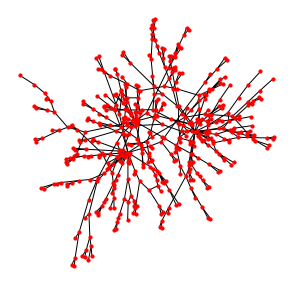

In [18]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)

nx.draw_spring(G,with_labels = False,node_size = 10, node_color =  'r', node_shape = 'o')

Get an estimate of the average clustering coefficient:

In [19]:
nx.average_clustering(G)

0.00899142265601893

For more examples how to examine graph properties, and for regenerating the plots in the paper using Mayavi, please look at the Multiple-Parameter Analysis Notebook.